<a href="https://colab.research.google.com/github/vianelk/ai_financial_track/blob/ZAC-ExplorationData/Ai_detect_financial_bankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AI DETECTION OF COMPAGNY'S BANKRUPT

In [ ]:
!pip install dataiku-api-client

  Using cached dataiku_api_client-13.4.1-py3-none-any.whl


## IMPORT OF LIBRARIES

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import dataikuapi as dataiku


## IMPORT OF DATASET

In [ ]:
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")

100%|██████████| 4.63M/4.63M [00:00<00:00, 6.42MB/s]

Extracting files...


In [ ]:
DATASET_PATH = './datasets'

In [ ]:
!mkdir -p {DATASET_PATH}

!cp -r {path}/* {DATASET_PATH}/

In [ ]:
df = pd.read_csv("datasets/data.csv")

df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## DATA TRANSFORMATION


In [ ]:
# Nettoyage des noms de colonnes (remplacement des espaces et des caractères spéciaux)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_').str.replace('(', '_').str.replace(')', '_')

In [ ]:
#Observer le type de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA_C__before_interest_and_depreciation_before_interest  6819 non-null   float64
 2   ROA_A__before_interest_and_%_after_tax                   6819 non-null   float64
 3   ROA_B__before_interest_and_depreciation_after_tax        6819 non-null   float64
 4   Operating_Gross_Margin                                   6819 non-null   float64
 5   Realized_Sales_Gross_Margin                              6819 non-null   float64
 6   Operating_Profit_Rate                                    6819 non-null   float64
 7   Pre_tax_net_Interest_Rate                                6819 non-null   float64
 8   After_tax_net_Interest_Rate 

In [ ]:
 #Vérification de valeurs nulles dans le dataset
 df.isnull().sum()

,0
Bankrupt?,0
ROA_C__before_interest_and_depreciation_before_interest,0
ROA_A__before_interest_and_%_after_tax,0
ROA_B__before_interest_and_depreciation_after_tax,0
Operating_Gross_Margin,0
...,...
Liability_to_Equity,0
Degree_of_Financial_Leverage__DFL_,0
Interest_Coverage_Ratio__Interest_expense_to_EBIT_,0
Net_Income_Flag,0


In [ ]:
#Recherche de colonne en double
df.duplicated().sum()

0

In [ ]:
# Recherche de valeur NAN
[print(col) for col in df if df[col].isna().sum() > 0]

[]

## DATA EXPLORATION

**X86 - Net Income to Total Assets (Rentabilité des actifs)**
<br>→ Mesure le profit net par rapport aux actifs.
<br>✔ Élevé = Bonne rentabilité et efficacité.
<br>✖ Faible/Négatif = Risque de faillite.

<br>**X69 - Total income / Total expense (Revenus / Dépenses)**
<br>→ Compare les revenus aux dépenses.
<br>✔ > 1 = Entreprise viable.
<br>✖ < 1 = Dépenses supérieures aux revenus, risque de pertes.

<br>**X40 - Borrowing dependency (Dépendance aux emprunts)**
<br>→ Indique la part des coûts financiers liée aux emprunts.
<br>✔ Faible = Moins de risque financier.
<br>✖ Élevé = Forte dépendance, risque accru en cas de baisse de revenus.

<br**>X68 - Retained Earnings to Total Assets (Bénéfices non répartis / Actifs)**
<br>→ Montre combien des actifs sont financés par les bénéfices passés.
<br>✔ Élevé = Stabilité financière.
<br>✖ Faible = Forte dépendance aux emprunts/investisseurs.

<br>**X36 - Total debt / Total net worth (Ratio d’endettement)**
<br>→ Compare la dette totale aux fonds propres.
<br>✔ Faible = Bonne solidité financière.
<br>✖ Élevé = Flexibilité financière réduite, risque accru en cas de crise.

In [ ]:
# Sélection des colonnes d'intérêt avec les nouveaux noms
selected_columns = [
    "Net_Income_to_Total_Assets",
    "Total_income_Total_expense",
    "Borrowing_dependency",
    "Retained_Earnings_to_Total_Assets",
    "Total_debt_Total_net_worth"
]

df_selected = df[selected_columns]

In [ ]:
# Affichage des statistiques descriptives
stats_desc = df_selected.describe()
print("Statistiques descriptives :\n", stats_desc)

Statistiques descriptives :
        Net_Income_to_Total_Assets  Total_income_Total_expense  \
count                 6819.000000                 6819.000000   
mean                     0.807760                    0.002549   
std                      0.040332                    0.012093   
min                      0.000000                    0.000000   
25%                      0.796750                    0.002236   
50%                      0.810619                    0.002336   
75%                      0.826455                    0.002492   
max                      1.000000                    1.000000   

       Borrowing_dependency  Retained_Earnings_to_Total_Assets  \
count           6819.000000                        6819.000000   
mean               0.374654                           0.934733   
std                0.016286                           0.025564   
min                0.000000                           0.000000   
25%                0.370168                           0

**Net_Income_to_Total_Assets (Rentabilité des actifs)**
<br>→ Moyenne : 0.8077 (80% des actifs en revenu net)
<br>→ Peu de variation, certaines entreprises à 0, d’autres à 1.
<br>
<br>**Total_income_Total_expense (Revenus vs Dépenses)**
<br>→ Moyenne : 0.0025 (revenus ≈ dépenses)
<br>→ Variabilité élevée, certaines entreprises équilibrées, d’autres déficitaires.
<br>
<br>**Borrowing_dependency (Dépendance aux emprunts)**
<br>→ Moyenne : 37% des coûts financiers liés à la dette
<br>→ Faible variation, certaines entreprises sans dette, d’autres totalement dépendantes.
<br>
<br>**Retained_Earnings_to_Total_Assets (Bénéfices non répartis)**
<br>→ Moyenne : 93% des actifs financés en interne
<br>→ Stabilité forte, mais certaines entreprises sans bénéfices accumulés.
<br>
<br>**Total_debt_Total_net_worth (Ratio d’endettement)**
<br>→ Moyenne : 4.4M, Le ratio d'endettement moyen est très élevé
<br>→ Certaines entreprises sans dette, d’autres extrêmement endettées.

In [ ]:
# Détection des corrélations (Evite redondance, identifie les tendances)
correlation_matrix = df_selected.corr()

<Figure size 1200x600 with 0 Axes>

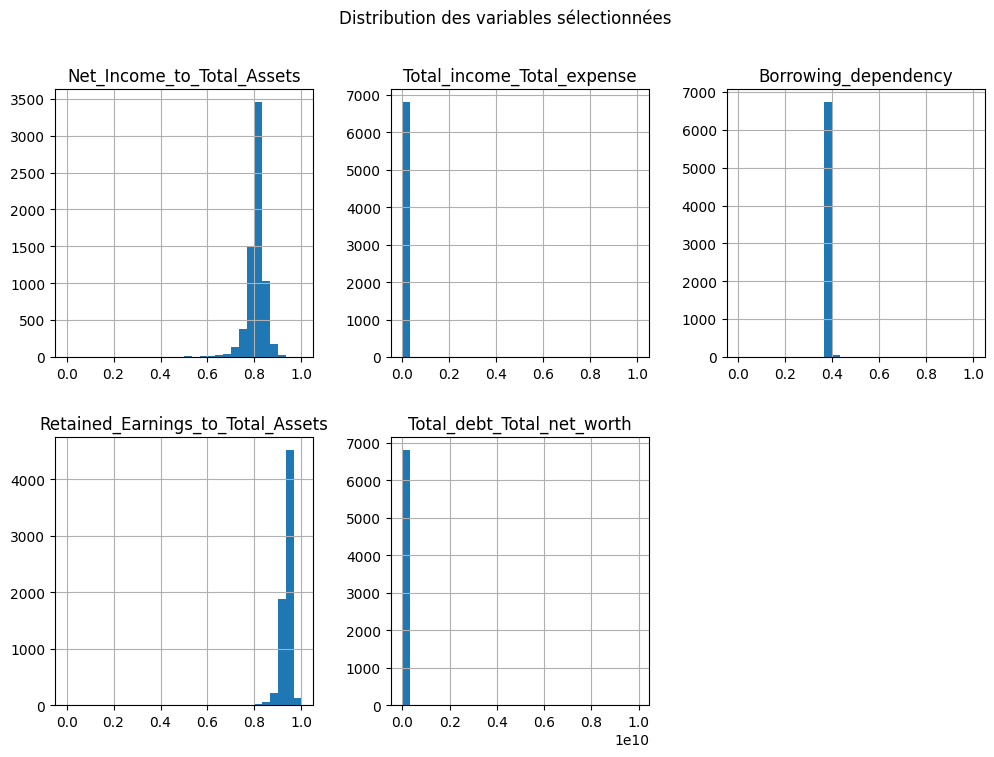

In [ ]:
# Visualisation des distributions (Histogrammes)
plt.figure(figsize=(12, 6))
df_selected.hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.suptitle("Distribution des variables sélectionnées")
plt.show()

**Interpretation**


*   **Net Income to Total Assets** : La majorité des entreprises ont un ratio compris entre 0.75 et 0.85, ce qui montre une forte concentration autour d’une rentabilité stable.

*   **Total income / Total expense** : La distribution est très asymétrique, avec une majorité d'entreprises ayant un ratio très faible.


*   **Borrowing dependency**: La plupart des entreprises ont une dépendance aux emprunts concentrée autour de 0.37.

*   **Retained Earnings to Total Assets** : La plupart des entreprises financent presque 100% de leurs actifs avec leurs bénéfices.


*   **Total debt / Total net worth** : Cette variable a une dispersion plus large, avec certaines entreprises ayant des niveaux de dette extrêmement élevés, ce qui peut indiquer des risques financiers importants.


















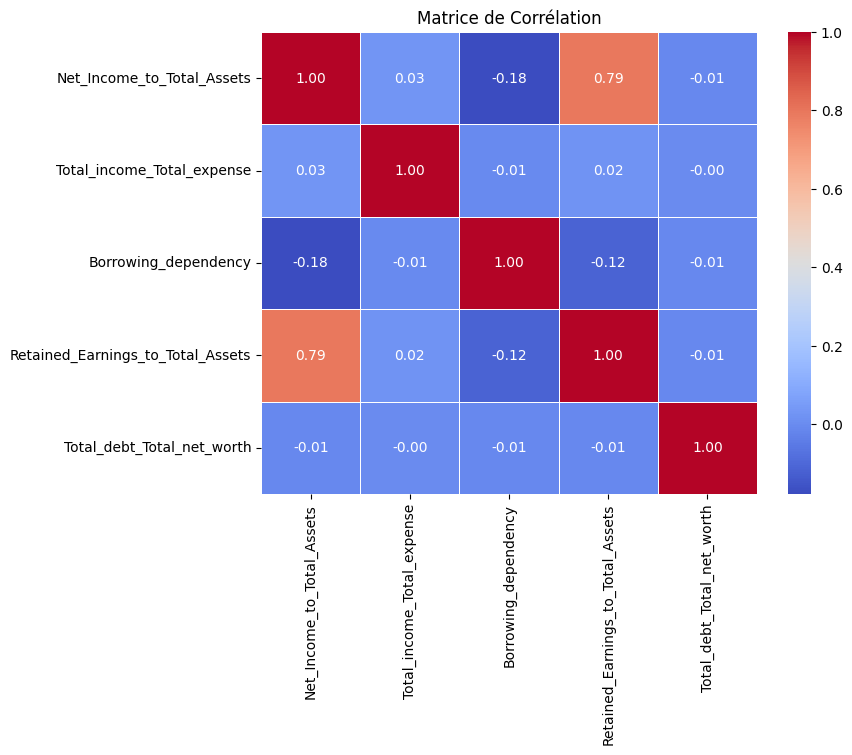

In [ ]:
# Heatmap des corrélations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

**Conclusion**: Les entreprises les plus performantes sont celles qui :

*   Réduisent leurs coûts fixes pour augmenter la rentabilité
*   Évitent une trop forte dépendance aux emprunts.
*   Réduisent leurs coûts fixes pour augmenter la rentabilité.


## EXPORT TO DATAIKU

In [ ]:
dataiku_url = 'https://dss-c8b1fb04-e440c9ef-dku.eu-west-3.app.dataiku.io/projects/AI_FINANCIAL_TRACK/'
dataiku_api_key = 'api key'

external_client = dataiku.DSSClient(dataiku_url, dataiku_api_key)

external_client